In [1]:
"""Zbior danych pochodzi ze strony: https://www.kaggle.com/dronio/SolarEnergy
Szukalam czegos zwiazanego z energetyka, poniewaz ten temat mnie interesuje :)"""

'Zbior danych pochodzi ze strony: https://www.kaggle.com/dronio/SolarEnergy\nSzukalam czegos zwiazanego z energetyka, poniewaz ten temat mnie interesuje :)'

In [2]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime

from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import sklearn.metrics as metrics

from sklearn.preprocessing import StandardScaler # data normalization
from sklearn.cluster import KMeans # K-means algorithm
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [3]:
data = pd.read_csv('SolarPrediction.csv', sep=',')

data.columns

Index(['UNIXTime', 'Data', 'Time', 'Radiation', 'Temperature', 'Pressure',
       'Humidity', 'WindDirection(Degrees)', 'Speed', 'TimeSunRise',
       'TimeSunSet'],
      dtype='object')

In [4]:
data.shape

(32686, 11)

In [5]:
data.describe()

,UNIXTime,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed
count,3.268600e+04,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000
mean,1.478047e+09,207.124697,51.103255,30.422879,75.016307,143.489821,6.243869
std,3.005037e+06,315.916387,6.201157,0.054673,25.990219,83.167500,3.490474
min,1.472724e+09,1.110000,34.000000,30.190000,8.000000,0.090000,0.000000
25%,1.475546e+09,1.230000,46.000000,30.400000,56.000000,82.227500,3.370000
50%,1.478026e+09,2.660000,50.000000,30.430000,85.000000,147.700000,5.620000
75%,1.480480e+09,354.235000,55.000000,30.460000,97.000000,179.310000,7.870000
max,1.483265e+09,1601.260000,71.000000,30.560000,103.000000,359.950000,40.500000


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32686 entries, 0 to 32685
Data columns (total 11 columns):
UNIXTime                  32686 non-null int64
Data                      32686 non-null object
Time                      32686 non-null object
Radiation                 32686 non-null float64
Temperature               32686 non-null int64
Pressure                  32686 non-null float64
Humidity                  32686 non-null int64
WindDirection(Degrees)    32686 non-null float64
Speed                     32686 non-null float64
TimeSunRise               32686 non-null object
TimeSunSet                32686 non-null object
dtypes: float64(4), int64(3), object(4)
memory usage: 2.7+ MB


In [7]:
data.isnull().sum()

UNIXTime                  0
Data                      0
Time                      0
Radiation                 0
Temperature               0
Pressure                  0
Humidity                  0
WindDirection(Degrees)    0
Speed                     0
TimeSunRise               0
TimeSunSet                0
dtype: int64

In [8]:
data.isna().sum()

UNIXTime                  0
Data                      0
Time                      0
Radiation                 0
Temperature               0
Pressure                  0
Humidity                  0
WindDirection(Degrees)    0
Speed                     0
TimeSunRise               0
TimeSunSet                0
dtype: int64

In [9]:
data.rename({'Speed': 'WindSpeed'}, axis=1, inplace=True) #inplace - modyfikujemy obiekt i nic nie zwracamy; bez tego tworzymy kopię
data = data.sort_values('UNIXTime',ascending=True) 
#data.index =  pd.to_datetime(data['UNIXTime'], unit='s')

In [10]:
#modyfikuje dane, tak zeby uzyskac wiecej szczegolow
data['Date'] =  pd.to_datetime(data['Data'])

data['Time'] =  pd.to_datetime(data['Time'], format='%H:%M:%S')

data['Year'], data['Month'], data['Day'] = data['Date'].dt.year, data['Date'].dt.month, data['Date'].dt.day
data['Hour'], data['Minute'], data['Second'] = data['Time'].dt.hour, data['Time'].dt.minute, data['Time'].dt.second
data['TimeSunRise'] = pd.to_datetime(data['TimeSunRise'], format = '%H:%M:%S')
data['TimeSunSet'] = pd.to_datetime(data['TimeSunSet'], format='%H:%M:%S')
data['DayLength(s)'] = data['TimeSunSet'].dt.hour*60*60 \
                           + data['TimeSunSet'].dt.minute*60 \
                           + data['TimeSunSet'].dt.second \
                           - data['TimeSunRise'].dt.hour*60*60 \
                           - data['TimeSunRise'].dt.minute*60 \
                           - data['TimeSunRise'].dt.second

data['DayOfYear'] = data['Date'].dt.dayofyear
data['Temperature'] = (data['Temperature'] - 32) * 5/9      #zmieniam jednostke na st C, zeby bylo mi latwiej przegladac dane
data.drop(['Data', 'Time', 'Date', 'TimeSunRise','TimeSunSet'], inplace=True, axis=1)

In [11]:
print(data.head())
print(data.dtypes)
data.describe()

        UNIXTime  Radiation  Temperature  Pressure  Humidity  \
7416  1472724008       2.58    10.555556     30.43       103   
7415  1472724310       2.83    10.555556     30.43       103   
7414  1472725206       2.16    10.555556     30.43       103   
7413  1472725505       2.21    10.555556     30.43       103   
7412  1472725809       2.25    10.555556     30.43       103   

      WindDirection(Degrees)  WindSpeed  Year  Month  Day  Hour  Minute  \
7416                   77.27      11.25  2016      9    1     0       0   
7415                  153.44       9.00  2016      9    1     0       5   
7414                  142.04       7.87  2016      9    1     0      20   
7413                  144.12      18.00  2016      9    1     0      25   
7412                   67.42      11.25  2016      9    1     0      30   

      Second  DayLength(s)  DayOfYear  
7416       8         45060        245  
7415      10         45060        245  
7414       6         45060        245  
7413

,UNIXTime,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),WindSpeed,Year,Month,Day,Hour,Minute,Second,DayLength(s),DayOfYear
count,3.268600e+04,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.0,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000
mean,1.478047e+09,207.124697,10.612920,30.422879,75.016307,143.489821,6.243869,2016.0,10.526066,15.825766,11.557425,27.556691,17.441902,41433.032491,306.110965
std,3.005037e+06,315.916387,3.445087,0.054673,25.990219,83.167500,3.490474,0.0,1.096691,8.711824,6.912034,17.268507,12.951109,1795.873502,34.781367
min,1.472724e+09,1.110000,1.111111,30.190000,8.000000,0.090000,0.000000,2016.0,9.000000,1.000000,0.000000,0.000000,0.000000,39360.000000,245.000000
25%,1.475546e+09,1.230000,7.777778,30.400000,56.000000,82.227500,3.370000,2016.0,10.000000,9.000000,6.000000,15.000000,5.000000,39720.000000,277.000000
50%,1.478026e+09,2.660000,10.000000,30.430000,85.000000,147.700000,5.620000,2016.0,11.000000,16.000000,12.000000,30.000000,18.000000,41040.000000,306.000000
75%,1.480480e+09,354.235000,12.777778,30.460000,97.000000,179.310000,7.870000,2016.0,11.000000,23.000000,18.000000,45.000000,22.000000,42900.000000,334.000000
max,1.483265e+09,1601.260000,21.666667,30.560000,103.000000,359.950000,40.500000,2016.0,12.000000,31.000000,23.000000,57.000000,59.000000,45060.000000,366.000000


In [12]:
description = data.groupby(['Month', 'Hour']).describe().Radiation
#description.reset_index(inplace=True)
description

count        mean         std     min       25%       50%  \
Month Hour                                                              
9     0     238.0    1.697311    0.644430    1.17    1.2300     1.260   
      1     328.0    1.889055    0.798699    1.18    1.2300     1.390   
      2     332.0    1.900753    0.799765    1.16    1.2300     1.405   
      3     331.0    1.818671    0.701346    1.17    1.2300     1.280   
      4     334.0    1.814760    0.676358    1.17    1.2200     1.435   
      5     326.0    1.788252    0.703298    1.15    1.2300     1.270   
      6     305.0   16.153115   16.066311    1.26    7.2700    13.960   
      7     300.0  239.668200  120.664193   20.00  154.6300   244.665   
      8     304.0  474.606020  152.391702   23.54  425.0475   505.905   
      9     306.0  655.666601  212.607177   34.95  621.8425   731.925   
      10    298.0  818.366611  247.600929  133.57  756.9400   908.765   
      11    273.0  824.924725  320.376437   59.48  516.8600  1003.030   
      12    275.0  772.102655  376.270553   32.15  374.2500  1026.570   
      13    304.0  664.178388  376.588806   47.01  230.8975   872.820   
      14    299.0  532.883545  339.020439   26.83  203.2150   470.020   
      15    296.0  422.858581  249.416946   18.90  208.7150   410.410   
      16    299.0  249.814482  172.052525   24.28   97.6400   210.100   
      17    296.0  105.951588   90.980961    5.49   36.6650    70.115   
      18    316.0    8.074620   12.116797    1.18    1.3375     3.085   
      19    331.0    1.729577    0.604460    1.19    1.2400     1.300   
      20    333.0    1.706547    0.604618    1.17    1.2400     1.270   
      21    332.0    1.754458    0.668151    1.18    1.2400     1.275   
      22    331.0    1.695529    0.618482    1.19    1.2300     1.270   
      23    330.0    1.723061    0.657962    1.17    1.2300     1.270   
10    0     297.0    1.226801    0.027005    1.13    1.2100     1.230   
      1     370.0    1.226919    0.026539    1.14    1.2100     1.230   
      2     368.0    1.227391    0.024522    1.15    1.2100     1.220   
      3     369.0    1.226504    0.025021    1.17    1.2100     1.220   
      4     372.0    1.224435    0.024658    1.15    1.2100     1.220   
      5     370.0    1.223514    0.025302    1.16    1.2100     1.220   
...           ...         ...         ...     ...       ...       ...   
11    18    348.0    1.233649    0.077550    1.16    1.2100     1.230   
      19    338.0    1.220680    0.021989    1.15    1.2100     1.220   
      20    336.0    1.221518    0.022148    1.16    1.2100     1.220   
      21    336.0    1.215774    0.023334    1.15    1.2000     1.220   
      22    336.0    1.215238    0.022246    1.15    1.2000     1.210   
      23    336.0    1.212917    0.021919    1.15    1.2000     1.210   
12    0     331.0    1.230483    0.035459    1.15    1.2100     1.220   
      1     336.0    1.230982    0.036560    1.13    1.2100     1.230   
      2     336.0    1.230238    0.037216    1.11    1.2100     1.230   
      3     336.0    1.231220    0.036878    1.15    1.2100     1.220   
      4     335.0    1.229194    0.035817    1.15    1.2000     1.220   
      5     336.0    1.231458    0.036232    1.15    1.2100     1.230   
      6     336.0    2.291101    3.007135    1.15    1.2100     1.250   
      7     336.0   28.260744   23.481861    1.19   12.8900    20.950   
      8     335.0  211.472209  147.034544    3.25   82.2900   177.780   
      9     335.0  360.543910  214.345381    8.52  157.4700   409.880   
      10    335.0  456.808925  272.913121   10.24  206.2100   455.930   
      11    345.0  473.817536  301.599152   14.14  205.0400   422.330   
      12    346.0  526.824162  317.703917   35.30  200.4925   500.630   
      13    348.0  466.523764  308.851751   19.41  180.8800   403.230   
      14    347.0  369.472824  286.249859    9.09  108.4800   280.080   
      15    345.0  276.515884  203.000788   10.34  100.1200   218.430 

In [13]:
data.filter(items =['Temperature','Radiation']).describe()

,Temperature,Radiation
count,32686.000000,32686.000000
mean,10.612920,207.124697
std,3.445087,315.916387
min,1.111111,1.110000
25%,7.777778,1.230000
50%,10.000000,2.660000
75%,12.777778,354.235000
max,21.666667,1601.260000


In [14]:
cols = list(data.columns.values)
cols

['UNIXTime',
 'Radiation',
 'Temperature',
 'Pressure',
 'Humidity',
 'WindDirection(Degrees)',
 'WindSpeed',
 'Year',
 'Month',
 'Day',
 'Hour',
 'Minute',
 'Second',
 'DayLength(s)',
 'DayOfYear']

In [15]:
#zmieniam kolejnosc kolumn
data = data[['UNIXTime', 'Radiation', 'Temperature', 'Pressure', 'Humidity', 'WindDirection(Degrees)', 'WindSpeed', 'DayOfYear', 'Hour', 'Minute', 'Second', 'DayLength(s)', 'Year', 'Month', 'Day']]

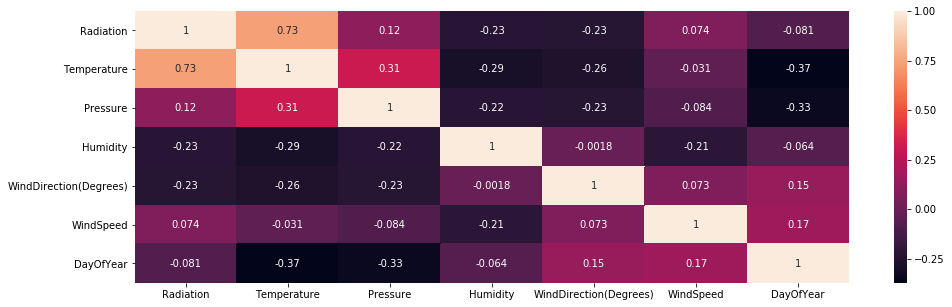

In [16]:
corrMatrix = data.iloc[:,1:8].corr()
plt.figure(figsize=(16,5))
sns.heatmap(corrMatrix, annot=True)
plt.show()
#plt.savefig('heatmap.pdf')

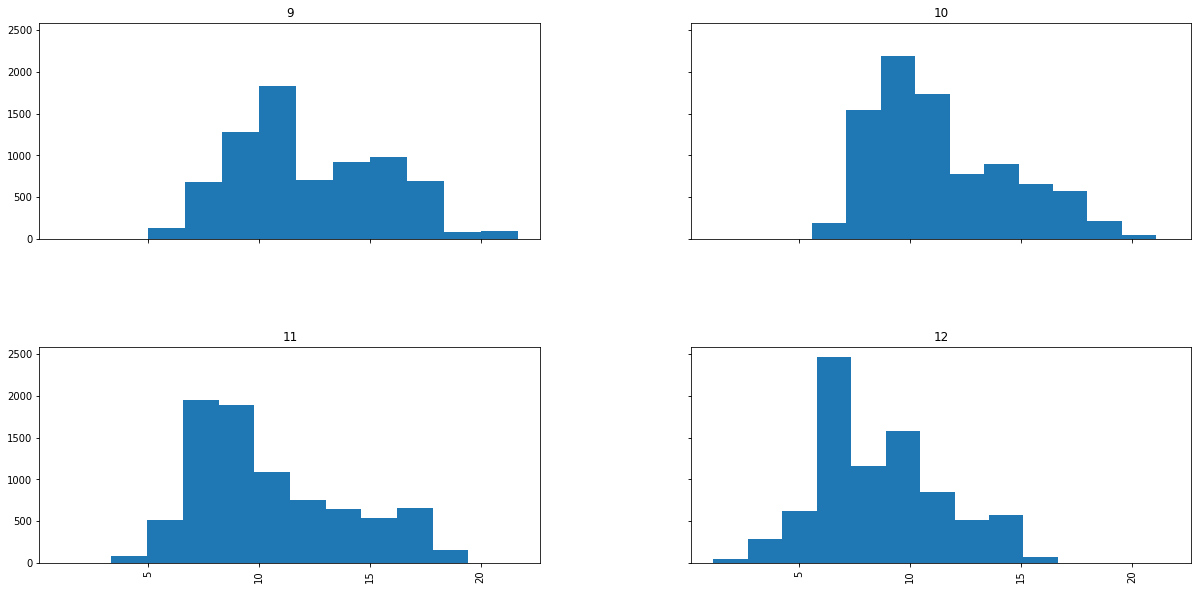

In [17]:
data.hist(column='Temperature', by='Month', bins=10, figsize=(20,10), sharex= True, sharey = True);

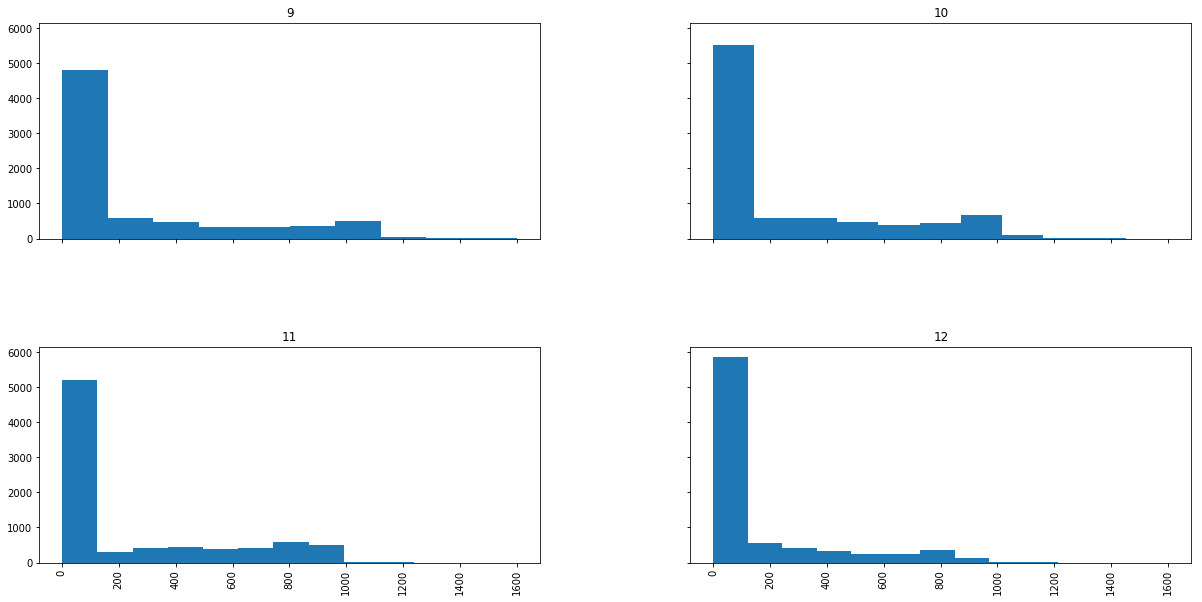

In [18]:
data.hist(column='Radiation', by='Month', bins=10, figsize=(20,10), sharex= True, sharey = True);

Text(0.5, 0, '')

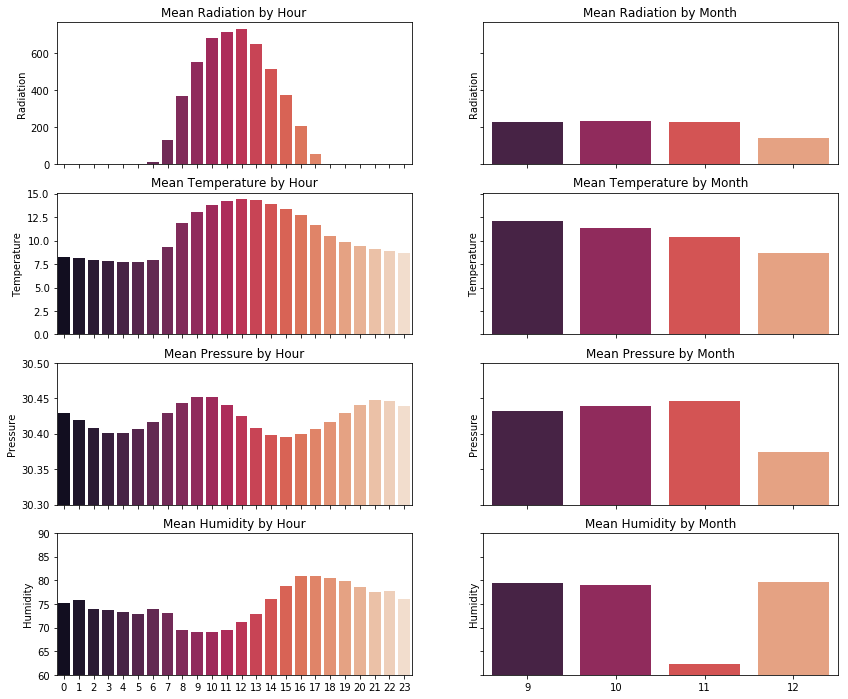

In [19]:
#dodatkowo robie porownanie wartosci po godzinach i po miesiacach
grouped_m = data.groupby('Month').mean().reset_index()
grouped_h = data.groupby('Hour').mean().reset_index()

f, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2, sharex='col', sharey='row', figsize=(14,12))

ax1.set_title('Mean Radiation by Hour')
g = sns.barplot(x='Hour', y='Radiation', data=grouped_h, palette="rocket", ax=ax1)
ax1.set_xlabel('')

ax2.set_title('Mean Radiation by Month')
g = sns.barplot(x='Month', y='Radiation', data=grouped_m, palette="rocket", ax=ax2)
ax2.set_xlabel('')

ax3.set_title('Mean Temperature by Hour')
g = sns.barplot(x='Hour', y='Temperature', data=grouped_h, palette="rocket", ax=ax3)
ax3.set_xlabel('')

ax4.set_title('Mean Temperature by Month')
g = sns.barplot(x='Month', y='Temperature', data=grouped_m, palette="rocket", ax=ax4)
ax4.set_xlabel('')

ax5.set_title('Mean Pressure by Hour')
g = sns.barplot(x='Hour', y='Pressure', data=grouped_h, palette="rocket", ax=ax5)
ax5.set_xlabel('')
ax5.set_ylim(30.3, 30.5)

ax6.set_title('Mean Pressure by Month')
g = sns.barplot(x='Month', y='Pressure', data=grouped_m, palette="rocket", ax=ax6)
ax6.set_xlabel('')

ax7.set_title('Mean Humidity by Hour')
g = sns.barplot(x='Hour', y='Humidity', data=grouped_h, palette="rocket", ax=ax7)
ax7.set_xlabel('')
ax7.set_ylim(60, 90)

ax8.set_title('Mean Humidity by Month')
g = sns.barplot(x='Month', y='Humidity', data=grouped_m, palette="rocket", ax=ax8)
ax8.set_xlabel('')

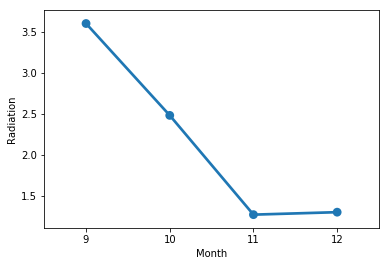

In [20]:
df = data[['Radiation','Month']].groupby(["Month"]).median().reset_index()
#print(df)
sns.pointplot(x='Month', y='Radiation', data=df);

   Month  Temperature
0      9    11.666667
1     10    10.555556
2     11     9.444444
3     12     8.333333


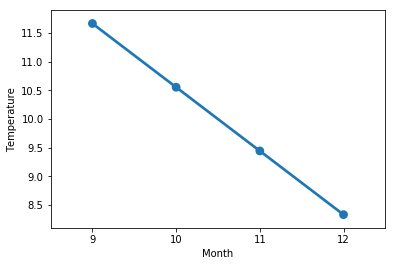

In [21]:
df = data[['Temperature','Month']].groupby(["Month"]).median().reset_index()
print(df)
sns.pointplot(x='Month', y='Temperature', data=df);

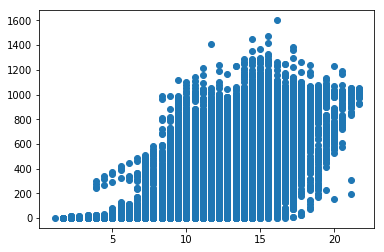

In [22]:
plt.scatter(data.Temperature, data.Radiation);

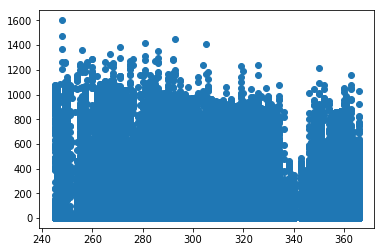

In [23]:
plt.scatter(data.DayOfYear, data.Radiation);

In [24]:
#sns.boxplot(y=data["Month"], x=data["Radiation"]);
#plt.show()

In [25]:
x = data['Temperature'].values[:,np.newaxis] 
y = data['Radiation'].values

model = LinearRegression()
model.fit(x, y) 
y_pred = model.predict(x)

r2 = metrics.r2_score(y, y_pred)
print('r2: ', r2)   #r2=0.54 to niezbyt duza wartosc, ale temperatura jest najbardziej skorelowana z promieniowaniem slonecznych
mae = metrics.mean_absolute_error(y, y_pred) 
print('MAE: ', mae)
mse = metrics.mean_squared_error(y, y_pred)      #wysoka wartosc MSE -> duzo bledow grubych
print('MSE: ', mse)
print('RMSE: ', np.sqrt(mse))

r2:  0.5401584925375958
MAE:  163.57065859188228
MSE:  45892.23316831565
RMSE:  214.22472585655385


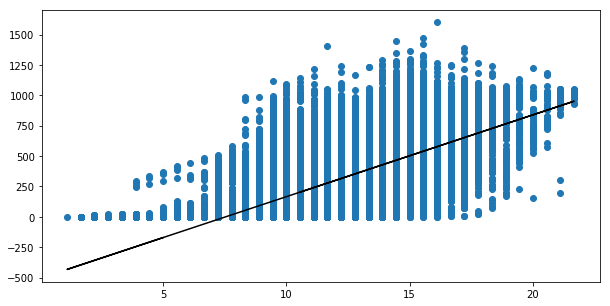

In [26]:
plt.figure(figsize=(10,5))
plt.scatter(x, y) # wykres punktowy zależności Radiation od Temperature
plt.plot(x, y_pred, 'k') # dopasowana krzywa regresji
plt.show()

In [27]:
# sprawdzenie metoda Ordinary Least Squares:
x = data['Temperature'].values
x2 = sm.add_constant(x) 
y = data['Radiation'].values
model = sm.OLS(y, x2, missing='drop')
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.540
Model:                            OLS   Adj. R-squared:                  0.540
Method:                 Least Squares   F-statistic:                 3.839e+04
Date:                Fri, 09 Apr 2021   Prob (F-statistic):               0.00
Time:                        10:47:54   Log-Likelihood:            -2.2181e+05
No. Observations:               32686   AIC:                         4.436e+05
Df Residuals:                   32684   BIC:                         4.436e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -508.1410      3.838   -132.400      0.0

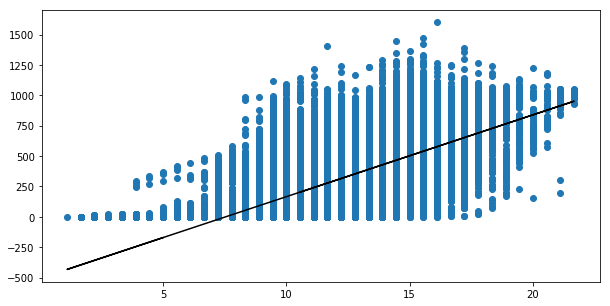

In [28]:
plt.figure(figsize=(10,5))
plt.scatter(x, y) # wykres punktowy zależności Radiation od Temperature
plt.plot(x, result.fittedvalues, 'k');

In [29]:
# sprawdzenie dla wiekszej ilosci danych na wejsciu
x = data[['Temperature', 'Humidity', 'Hour', 'DayOfYear', 'Pressure', 'WindDirection(Degrees)', 'WindSpeed', 'DayLength(s)']]
x = sm.add_constant(x)
y = data['Radiation']
model = sm.OLS(y, x, missing='drop')
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:              Radiation   R-squared:                       0.621
Model:                            OLS   Adj. R-squared:                  0.620
Method:                 Least Squares   F-statistic:                     6681.
Date:                Fri, 09 Apr 2021   Prob (F-statistic):               0.00
Time:                        10:47:55   Log-Likelihood:            -2.1866e+05
No. Observations:               32686   AIC:                         4.373e+05
Df Residuals:                   32677   BIC:                         4.374e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   1.07

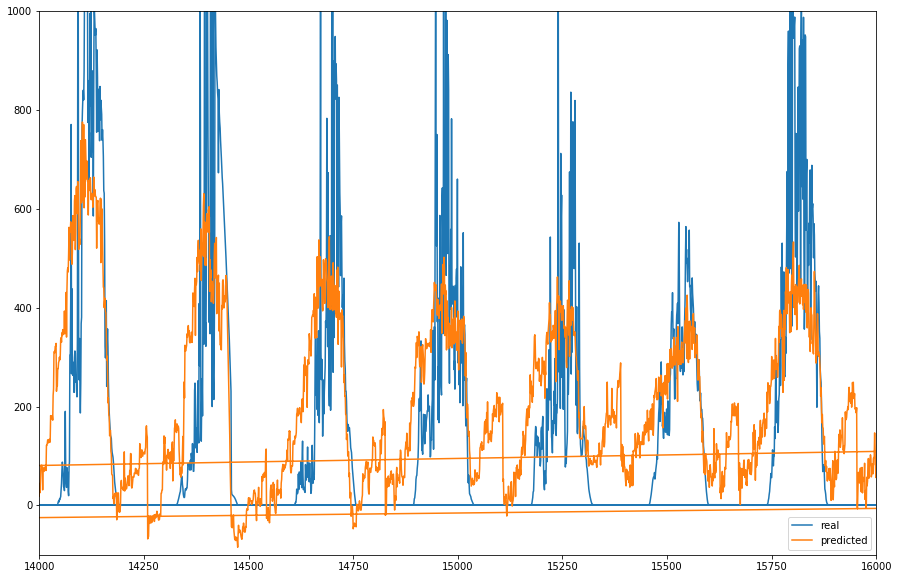

In [30]:
plt.figure(figsize=(15,10))
plt.plot(y, label="real")
plt.plot(result.fittedvalues, label="predicted")
plt.legend()
plt.axis([14000,16000, -100,1000]);  #biore wycinek z calosci, niestety model nie jest zbyt dobrze dopasowany, ale jeszcze nie umiem go poprawic :( bede nad tym pracowac

In [31]:
data

,UNIXTime,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),WindSpeed,DayOfYear,Hour,Minute,Second,DayLength(s),Year,Month,Day
7416,1472724008,2.58,10.555556,30.43,103,77.27,11.25,245,0,0,8,45060,2016,9,1
7415,1472724310,2.83,10.555556,30.43,103,153.44,9.00,245,0,5,10,45060,2016,9,1
7414,1472725206,2.16,10.555556,30.43,103,142.04,7.87,245,0,20,6,45060,2016,9,1
7413,1472725505,2.21,10.555556,30.43,103,144.12,18.00,245,0,25,5,45060,2016,9,1
7412,1472725809,2.25,10.555556,30.43,103,67.42,11.25,245,0,30,9,45060,2016,9,1
7411,1472726704,2.15,10.555556,30.43,103,67.85,4.50,245,0,45,4,45060,2016,9,1
7410,1472727006,2.07,10.555556,30.43,103,156.58,1.12,245,0,50,6,45060,2016,9,1
7409,1472727304,2.06,11.111111,30.43,103,69.98,7.87,245,0,55,4,45060,2016,9,1
7408,1472727607,2.10,11.111111,30.43,103,92.15,4.50,245,1,0,7,45060,2016,9,1
7407,1472727905,2.07,11.111111,30.42,103,68.17,4.50,245,1,5,5,45060,2016,9,1


In [32]:
data = data.iloc[:,1:8]
data

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),WindSpeed,DayOfYear
7416,2.58,10.555556,30.43,103,77.27,11.25,245
7415,2.83,10.555556,30.43,103,153.44,9.00,245
7414,2.16,10.555556,30.43,103,142.04,7.87,245
7413,2.21,10.555556,30.43,103,144.12,18.00,245
7412,2.25,10.555556,30.43,103,67.42,11.25,245
7411,2.15,10.555556,30.43,103,67.85,4.50,245
7410,2.07,10.555556,30.43,103,156.58,1.12,245
7409,2.06,11.111111,30.43,103,69.98,7.87,245
7408,2.10,11.111111,30.43,103,92.15,4.50,245
7407,2.07,11.111111,30.42,103,68.17,4.50,245


In [33]:
data.describe()

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),WindSpeed,DayOfYear
count,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000
mean,207.124697,10.612920,30.422879,75.016307,143.489821,6.243869,306.110965
std,315.916387,3.445087,0.054673,25.990219,83.167500,3.490474,34.781367
min,1.110000,1.111111,30.190000,8.000000,0.090000,0.000000,245.000000
25%,1.230000,7.777778,30.400000,56.000000,82.227500,3.370000,277.000000
50%,2.660000,10.000000,30.430000,85.000000,147.700000,5.620000,306.000000
75%,354.235000,12.777778,30.460000,97.000000,179.310000,7.870000,334.000000
max,1601.260000,21.666667,30.560000,103.000000,359.950000,40.500000,366.000000


In [34]:
data_s = StandardScaler().fit_transform(data)   #przeskalowane wartosci
pd.DataFrame(data_s)

,0,1,2,3,4,5,6
0,-0.647475,-0.016651,0.130250,1.076717,-0.796235,1.434249,-1.757030
1,-0.646683,-0.016651,0.130250,1.076717,0.119642,0.789627,-1.757030
2,-0.648804,-0.016651,0.130250,1.076717,-0.017433,0.465884,-1.757030
3,-0.648646,-0.016651,0.130250,1.076717,0.007577,3.368113,-1.757030
4,-0.648519,-0.016651,0.130250,1.076717,-0.914672,1.434249,-1.757030
5,-0.648836,-0.016651,0.130250,1.076717,-0.909502,-0.499616,-1.757030
6,-0.649089,-0.016651,0.130250,1.076717,0.157398,-1.467981,-1.757030
7,-0.649121,0.144611,0.130250,1.076717,-0.883890,0.465884,-1.757030
8,-0.648994,0.144611,0.130250,1.076717,-0.617316,-0.499616,-1.757030
9,-0.649089,0.144611,-0.052658,1.076717,-0.905654,-0.499616,-1.757030


In [35]:
pca = PCA(n_components=4) #PCA z 4 zmiennymi 
data_r = pca.fit(data_s).transform(data_s)
pd.DataFrame(data_r)

,0,1,2,3
0,0.220192,-0.865883,-0.318213,-0.705836
1,-0.047289,-1.067626,-0.426788,0.242852
2,0.004278,-1.291190,-0.343235,0.209077
3,-0.089937,0.462710,-0.820274,-0.519090
4,0.256801,-0.890282,-0.291075,-0.807137
5,0.312632,-2.054584,0.021602,-0.303319
6,0.006946,-2.420942,-0.070115,0.857774
7,0.370403,-1.454264,-0.107896,-0.490609
8,0.315671,-1.981729,-0.013231,-0.013602
9,0.337400,-2.001977,0.167492,-0.227138


In [36]:
data_princ = pd.DataFrame(data = data_r, columns = ['principal_com_1', 'principal_com_2','principal_com_3', 'principal_com_4'])
data_princ

,principal_com_1,principal_com_2,principal_com_3,principal_com_4
0,0.220192,-0.865883,-0.318213,-0.705836
1,-0.047289,-1.067626,-0.426788,0.242852
2,0.004278,-1.291190,-0.343235,0.209077
3,-0.089937,0.462710,-0.820274,-0.519090
4,0.256801,-0.890282,-0.291075,-0.807137
5,0.312632,-2.054584,0.021602,-0.303319
6,0.006946,-2.420942,-0.070115,0.857774
7,0.370403,-1.454264,-0.107896,-0.490609
8,0.315671,-1.981729,-0.013231,-0.013602
9,0.337400,-2.001977,0.167492,-0.227138


In [37]:
pca.explained_variance_ratio_  #32% + 20% + 14% +12% = 78% wariancji 

array([0.32654615, 0.19914588, 0.14132848, 0.12218761])

In [38]:
pca.n_components_

4

In [39]:
#grupowanie zbiorow
clusters = 4  #podzial na 4 grupy
model = KMeans(init = 'k-means++', 
               n_clusters = clusters, 
               n_init = 12)
model.fit(data_princ)

labels = model.labels_

In [40]:
labels

array([1, 1, 1, ..., 0, 0, 0])

In [41]:
data['cluster_num'] = labels  #dopisanie do danych przynaleznosci do danej grupy
data.head()

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),WindSpeed,DayOfYear,cluster_num
7416,2.58,10.555556,30.43,103,77.27,11.25,245,1
7415,2.83,10.555556,30.43,103,153.44,9.00,245,1
7414,2.16,10.555556,30.43,103,142.04,7.87,245,1
7413,2.21,10.555556,30.43,103,144.12,18.00,245,2
7412,2.25,10.555556,30.43,103,67.42,11.25,245,1


In [42]:
data.groupby('cluster_num').mean()

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),WindSpeed,DayOfYear
cluster_num,,,,,,,
0,109.232278,7.817405,30.329096,87.889090,210.800444,6.782548,349.036769
1,75.083883,10.187302,30.431257,91.828274,133.953367,4.593939,286.944966
2,26.756278,8.727341,30.449256,54.227593,159.230599,8.270574,317.998238
3,714.711670,15.454831,30.444195,59.180599,95.608026,6.546738,296.933917


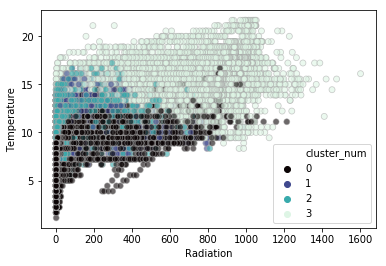

In [43]:
sns.scatterplot('Radiation', 'Temperature', 
               data = data, 
               hue = 'cluster_num', 
               palette = 'mako', 
               alpha = 0.6, 
               edgecolor = 'darkgrey',
               legend = 'full')